# Image Captioning with RNN
In this exercise, you will implement vanilla recurrent neural networks (RNNs) to train a model that can generate natural language captions for images.

Models in this exercise are highly similar to very early works in neural-network based image captioning. If you are interested to learn more, check out these two papers:

1. [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

# Preparation

## Google Colab Setup
First, run this cell load the autoreload extension. This allows us to edit .py source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [1]:
# %load_ext autoreload
# %autoreload 2

Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

## Check Environment
If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['utils', 'coco.pt', 'helper.py', 'rnn_captioning.py', 'HW8.ipynb']
```

In [3]:
import os

WORK_PATH = '/home/wsad1232885/NCKU/Deep_Vision/original/HW8/'
print(os.listdir(WORK_PATH))

['coco.pt', 'HW8.ipynb', '__pycache__', 'utils', 'rnn_captioning.py', 'helper.py']


Once you have successfully located the path to this assignment, run th following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from rnn_captioning.py!
```

as well as the last edit time for the file `rnn_lstm_attention_captioning.py`.

In [4]:
import sys
sys.path.append(WORK_PATH)

import time, os
os.environ["TZ"] = "Asia/Taipei"
time.tzset()

from rnn_captioning import *
from helper import *
hello_rnn_captioning()

py_path = os.path.join(WORK_PATH, 'rnn_captioning.py')
py_edit_time = time.ctime(os.path.getmtime(py_path))
print('rnn_captioning.py last edited on %s' % py_edit_time)

Hello from rnn_captioning.py!
rnn_captioning.py last edited on Fri Aug 16 18:04:41 2024


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [5]:
import math
import torch
from torch import nn
from torch.nn.parameter import Parameter
import torch.nn.functional as F

from utils.general import reset_seed, tensor_to_image, decode_captions, attention_visualizer
from utils.grad import rel_error, compute_numeric_gradient
import matplotlib.pyplot as plt
import time

# for plotting
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams["font.size"] = 12
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

We will use GPUs to accelerate our computation in this notebook. Run the following to make sure GPUs are enabled:

In [6]:
if torch.cuda.is_available():
  print(f'Good to go! (using {torch.cuda.get_device_name(0)})')
  DEVICE = torch.device("cuda")
else:
  print("Please set GPU via Edit -> Notebook Settings.")
  DEVICE = torch.device("cpu")

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

Good to go! (using NVIDIA GeForce RTX 4070 Ti SUPER)


# COCO Captions
For this exercise we will use the 2014 release of the [Microsoft COCO dataset](http://mscoco.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words.

You will later use MobileNet v2 to extract features for the images. A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` from `a4_helper.py` to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [7]:
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (112x112)
# "val_images" - resized validation images (112x112)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

# load COCO data from coco.pt, load_COCO is implemented in helper.py
data_dict = load_COCO(path = WORK_PATH+'coco.pt')

num_train = data_dict['train_images'].size(0)
num_val = data_dict['val_images'].size(0)

# declare variables for special tokens
NULL_index = data_dict['vocab']['token_to_idx']['<NULL>']
START_index = data_dict['vocab']['token_to_idx']['<START>']
END_index = data_dict['vocab']['token_to_idx']['<END>']
UNK_index = data_dict['vocab']['token_to_idx']['<UNK>']

train_images <class 'torch.Tensor'> torch.Size([10000, 3, 112, 112]) torch.uint8
train_captions <class 'torch.Tensor'> torch.Size([10000, 17]) torch.int64
val_images <class 'torch.Tensor'> torch.Size([500, 3, 112, 112]) torch.uint8
val_captions <class 'torch.Tensor'> torch.Size([500, 17]) torch.int64
vocab <class 'dict'> dict_keys(['idx_to_token', 'token_to_idx'])

Train images shape:  torch.Size([10000, 3, 112, 112])
Train caption tokens shape:  torch.Size([10000, 17])
Validation images shape:  torch.Size([500, 3, 112, 112])
Validation caption tokens shape:  torch.Size([500, 17])
total number of caption tokens:  864
mappings (list) from index to caption token:  ['<NULL>', '<START>', '<END>', '<UNK>', 'a', 'on', 'of', 'the', 'in', 'with', 'and', 'is', 'man', 'to', 'sitting', 'two', 'an', 'standing', 'people', 'are', 'at', 'next', 'white', 'woman', 'table', 'that', 'street', 'holding', 'some', 'person', 'down', 'large', 'top', 'group', 'tennis', 'field', 'it', 'plate', 'up', 'small', 'r

## Look at the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.

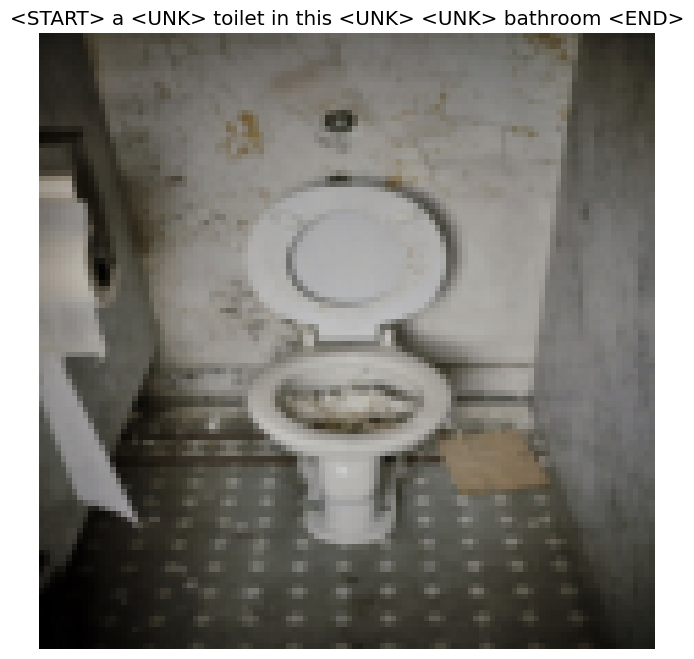

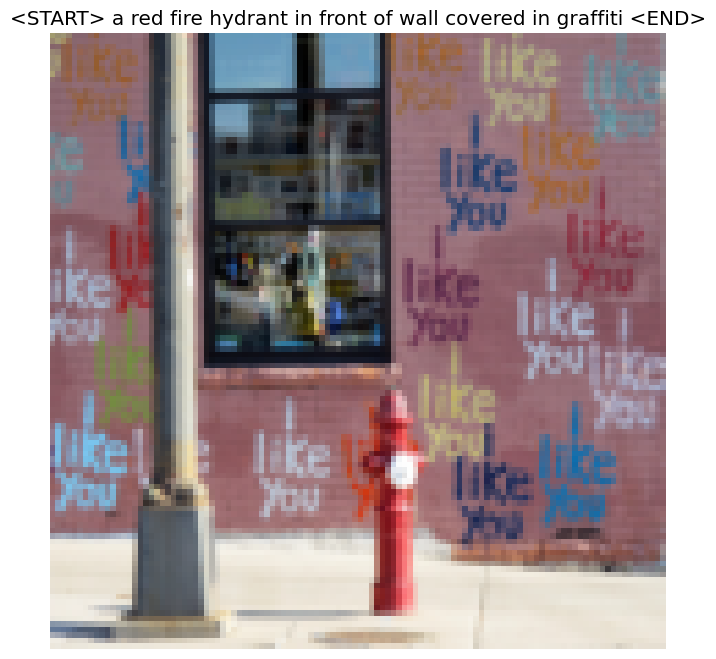

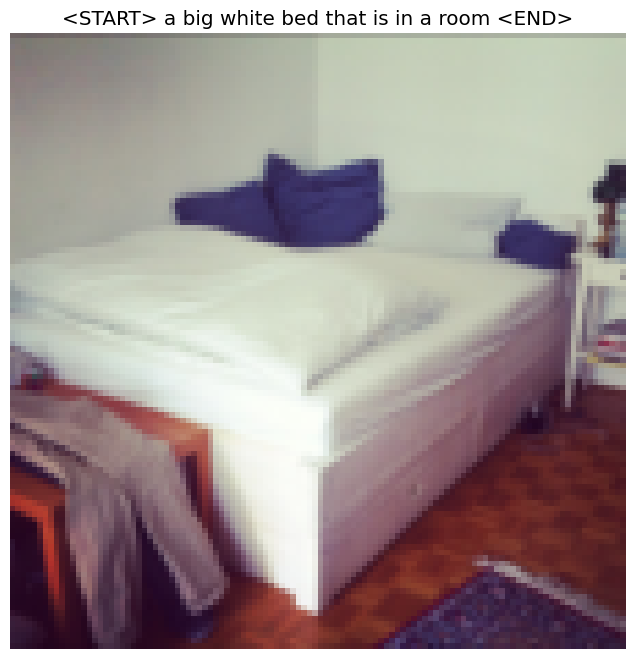

In [8]:
# Sample a minibatch and show the reshaped 112x112 images and captions
batch_size = 3

sample_idx = torch.randint(0, num_train, (batch_size,))
sample_images = data_dict['train_images'][sample_idx]
sample_captions = data_dict['train_captions'][sample_idx]
for i in range(batch_size):
  plt.imshow(sample_images[i].permute(1, 2, 0))
  plt.axis('off')
  caption_str = decode_captions(sample_captions[i], data_dict['vocab']['idx_to_token'])
  plt.title(caption_str)
  plt.show()

# Recurrent Neural Networks

## Vanilla RNN: step forward
First implement the `rnn_step_forward` for a single timestep of a vanilla recurrent neural network. Run the following to check your implementation. You should get a relative error less than `1e-8`.

In [9]:
N, D, H = 3, 10, 4

x = torch.linspace(-0.4, 0.7, steps=N*D, **to_double_cuda).reshape(N, D)
prev_h = torch.linspace(-0.2, 0.5, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.1, 0.9, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.3, 0.7, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.2, 0.4, steps=H, **to_double_cuda)

# YOUR_TURN: Impelement rnn_step_forward 
next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = torch.tensor([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]], **to_double_cuda)

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  2.3200594408551194e-09


## Vanilla RNN: step backward
Then implement the `rnn_step_backward` for a single timestep of a vanilla recurrent neural network. Run the following to numerically gradient check your implementation. You should get a relative error less than `1e-8`.

In [10]:
reset_seed(0)

N, D, H = 4, 5, 6
x = torch.randn(N, D, **to_double_cuda)
h = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = torch.randn(*out.shape, **to_double_cuda)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dnext_h)
dprev_h_num = compute_numeric_gradient(fh, h, dnext_h)
dWx_num = compute_numeric_gradient(fWx, Wx, dnext_h)
dWh_num = compute_numeric_gradient(fWh, Wh, dnext_h)
db_num = compute_numeric_gradient(fb, b, dnext_h)

# YOUR_TURN: Impelement rnn_step_backward
dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  3.530076340711781e-10
dprev_h error:  1.023333169118312e-09
dWx error:  1.3202843518520035e-10
dWh error:  3.002938529869191e-10
db error:  1.3316462459873777e-10


## Vanilla RNN: forward
Now that you have implemented the forward and backward passes for a single timestep of a vanilla RNN, you will combine these pieces to implement a RNN that processes an entire sequence of data. First implement `rnn_forward` by making calls to the `rnn_step_forward` function that you defined earlier.

Run the following to check your implementation. You should get a relative error less than `1e-6`.



In [11]:
N, T, D, H = 2, 3, 4, 5

x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
h0 = torch.linspace(-0.3, 0.1, steps=N*H, **to_double_cuda).reshape(N, H)
Wx = torch.linspace(-0.2, 0.4, steps=D*H, **to_double_cuda).reshape(D, H)
Wh = torch.linspace(-0.4, 0.1, steps=H*H, **to_double_cuda).reshape(H, H)
b = torch.linspace(-0.7, 0.1, steps=H, **to_double_cuda)

# YOUR_TURN: Impelement rnn_forward
h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = torch.tensor([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]], **to_double_cuda)
print('h error: ', rel_error(expected_h, h))

h error:  4.242275290213816e-09


## Vanilla RNN: backward
Implement the `rnn_backward` for a vanilla RNN. This should run back-propagation over the entire sequence, making calls to the `rnn_step_backward` function that you defined earlier. You should get a relative error less than `1e-6`.


In [12]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

x = torch.randn(N, T, D, **to_double_cuda)
h0 = torch.randn(N, H, **to_double_cuda)
Wx = torch.randn(D, H, **to_double_cuda)
Wh = torch.randn(H, H, **to_double_cuda)
b = torch.randn(H, **to_double_cuda)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# YOUR_TURN: Impelement rnn_backward
dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = compute_numeric_gradient(fx, x, dout)
dh0_num = compute_numeric_gradient(fh0, h0, dout)
dWx_num = compute_numeric_gradient(fWx, Wx, dout)
dWh_num = compute_numeric_gradient(fWh, Wh, dout)
db_num = compute_numeric_gradient(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.271931919688728e-09
dh0 error:  8.63806185798229e-10
dWx error:  5.161722983399557e-10
dWh error:  7.042436908041916e-10
db error:  9.360267729270615e-10


## Vanilla RNN: backward with autograd
Now it's time to introduce the lifesaver PyTorch Automatic Differantiation package - `torch.autograd`!

`torch.autograd` provides classes and functions implementing **automatic differentiation** of arbitrary scalar valued functions. It requires minimal changes to the existing code - if you pass tensors with `requires_grad=True` to the forward function you wrote earlier, you can just call `.backward(gradient=grad)` on the output to compute gradients on the input and weights.

Now we can compare the manual backward pass with the autograd backward pass. **Read through the following.**  You should get a relative error less than `1e-12`.

In [13]:
reset_seed(0)

N, D, T, H = 2, 3, 10, 5

# set requires_grad=True
x = torch.randn(N, T, D, **to_double_cuda, requires_grad=True)
h0 = torch.randn(N, H, **to_double_cuda, requires_grad=True)
Wx = torch.randn(D, H, **to_double_cuda, requires_grad=True)
Wh = torch.randn(H, H, **to_double_cuda, requires_grad=True)
b = torch.randn(H, **to_double_cuda, requires_grad=True)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = torch.randn(*out.shape, **to_double_cuda)

# manual backward
with torch.no_grad():
  dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

# backward with autograd
out.backward(dout) # the magic happens here!
dx_auto, dh0_auto, dWx_auto, dWh_auto, db_auto = \
  x.grad, h0.grad, Wx.grad, Wh.grad, b.grad

print('dx error: ', rel_error(dx_auto, dx))
print('dh0 error: ', rel_error(dh0_auto, dh0))
print('dWx error: ', rel_error(dWx_auto, dWx))
print('dWh error: ', rel_error(dWh_auto, dWh))
print('db error: ', rel_error(db_auto, db))

dx error:  9.703371940851615e-17
dh0 error:  9.134424184301861e-17
dWx error:  1.2423045378039655e-16
dWh error:  4.130139353689884e-17
db error:  1.990247337540126e-16


## RNN Module
We can now wrap the vanilla RNN we wrote into an `nn.Module`. `nn.Module` is a base class for all neural network modules, more details regarding its attributes, functions, and methods could be found [here](https://pytorch.org/docs/stable/nn.html?highlight=module#torch.nn.Module).

Here we want to set up a module for RNN, where function `__init__` sets up weight and biases, and function `forward` call the `rnn_forward` function from before.

**We have written this part in `RNN` for you but you are highly recommended to go through the code as you will write `modules` on your own later.**

All the implementation will be with `autograd` and `nn.Module` going forward. 

# RNN for image captioning
You will implement a few necessary tools and layers in order to build an image captioning model (class `CaptioningRNN`).

## Image Feature Extraction
Here, we use [MobileNet v2](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/) for image feature extraction. For vanilla RNN, we use the pooled CNN feature activation. Checkout the `FeatureExtractor` method in `rnn_captioning.py` to see the initialization of the model.

Now, let's see what's inside MobileNet v2. Assume we have a 3x112x112 image input. We pass argument `pooling=True` to the model so the CNN activation is spatially-pooled from `1280x4x4` to `1280`.

In [14]:
model = FeatureExtractor(pooling=True, verbose=True, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 56, 56]             864
       BatchNorm2d-2           [-1, 32, 56, 56]              64
             ReLU6-3           [-1, 32, 56, 56]               0
            Conv2d-4           [-1, 32, 56, 56]             288
       BatchNorm2d-5           [-1, 32, 56, 56]              64
             ReLU6-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 16, 56, 56]             512
       BatchNorm2d-8           [-1, 16, 56, 56]              32
  InvertedResidual-9           [-1, 16, 56, 56]               0
           Conv2d-10           [-1, 96, 56, 56]           1,536
      BatchNorm2d-11           [-1, 96, 56, 56]             192
            ReLU6-12           [-1, 96, 56, 56]               0
           Conv2d-13           [-1, 96, 28, 28]             864
      BatchNorm2d-14           [-1, 96,

/home/wsad1232885/anaconda3/envs/py-3.9/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Word embedding
In deep learning systems, we commonly represent words using vectors. Each word of the vocabulary will be associated with a vector, and these vectors will be learned jointly with the rest of the system.

Implement the module `WordEmbedding.forward` to convert words (represented by integers) into vectors. Run the following to check your implementation. You should get a relative error less than `1e-7`. 


In [15]:
N, T, V, D = 2, 4, 5, 3

x = torch.tensor([[0, 3, 1, 2], [2, 1, 0, 3]], **to_long_cuda)
W = torch.linspace(0, 1, steps=V*D, **to_double_cuda).reshape(V, D)

# YOUR_TURN: Impelement WordEmbedding
model_emb = WordEmbedding(V, D, **to_double_cuda)
model_emb.W_embed.data.copy_(W)
out = model_emb(x)
expected_out = torch.tensor([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]], **to_double_cuda)

print('out error: ', rel_error(expected_out, out))

out error:  2.727272753724473e-09


## Temporal Affine layer
At every timestep we use an affine function to transform the RNN hidden vector at that timestep into scores for each word in the vocabulary. This could be easily done with the [`nn.Linear`](https://pytorch.org/docs/master/nn.html#torch.nn.Linear) module. It can also work as a regular affine layer, like the one you have implemented from previous assignments. Run the following examples to see how it works. You will intensively use `nn.Linear` later.

In [16]:
reset_seed(0)

N, T, D, M = 2, 3, 4, 3

w = torch.linspace(-0.2, 0.4, steps=D*M, **to_double_cuda).reshape(D, M).permute(1, 0)
b = torch.linspace(-0.4, 0.1, steps=M, **to_double_cuda)

temporal_affine = nn.Linear(D, M).to(**to_double_cuda)
temporal_affine.weight.data.copy_(w)
temporal_affine.bias.data.copy_(b)

# For regular affine layer
x = torch.linspace(-0.1, 0.3, steps=N*D, **to_double_cuda).reshape(N, D)
out = temporal_affine(x)
print('affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[-0.35584416, -0.10896104,  0.13792208],
                     [-0.31428571, -0.01753247,  0.27922078]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))


# For temporal affine layer
x = torch.linspace(-0.1, 0.3, steps=N*T*D, **to_double_cuda).reshape(N, T, D)
out = temporal_affine(x)
print('\ntemporal affine layer - input shape: {}, output shape: {}'.format(x.shape, out.shape))
correct_out = torch.tensor([[[-0.39920949, -0.16533597,  0.06853755],
                             [-0.38656126, -0.13750988,  0.11154150],
                             [-0.37391304, -0.10968379,  0.15454545]],
                            [[-0.36126482, -0.08185771,  0.19754941],
                             [-0.34861660, -0.05403162,  0.24055336],
                             [-0.33596838, -0.02620553,  0.28355731]]], **to_double_cuda)

print('dx error: ', rel_error(out, correct_out))

affine layer - input shape: torch.Size([2, 4]), output shape: torch.Size([2, 3])
dx error:  6.021897849884195e-09

temporal affine layer - input shape: torch.Size([2, 3, 4]), output shape: torch.Size([2, 3, 3])
dx error:  6.039603964764421e-09


## Temporal Softmax loss
In an RNN language model, at every timestep we produce a score for each word in the vocabulary. We know the ground-truth word at each timestep, so we use a softmax loss function to compute loss and gradient at each timestep. We sum the losses over time and average them over the minibatch.

However there is one wrinkle: since we operate over minibatches and different captions may have different lengths, we append `<NULL>` tokens to the end of each caption so they all have the same length. We don't want these `<NULL>` tokens to count toward the loss or gradient, so in addition to scores and ground-truth labels our loss function also accepts a `ignore_index` that tells it which index in caption should be ignored when computing the loss.

Implement the `temporal_softmax_loss` and run the follwing cell to check if the implmentation is correct.

In [17]:
def check_loss(N, T, V, p):
    x = 0.001 * torch.randn(N, T, V, **to_double_cuda)
    y = torch.randint(V, size=(N, T), **to_long_cuda)
    mask = torch.rand(N, T, **to_double_cuda)
    y[mask > p] = 0
    # YOUR_TURN: Impelement temporal_softmax_loss
    print(temporal_softmax_loss(x, y, NULL_index).item())
  
check_loss(1000, 1, 10, 1.0)   # Should be about 2.00-2.11
check_loss(1000, 10, 10, 1.0)  # Should be about 20.6-21.0
check_loss(5000, 10, 10, 0.1) # Should be about 2.00-2.11

2.0815791002459583
20.790240421784695
2.0608051904129696


## Captioning Module
Now we are wrapping everything into the captioning module. Implement the `CaptioningRNN.__init__` function for initialization and the `CaptioningRNN.forward` for the forward pass.

Skip the `CaptioningRNN.sample` for now, we will come back to this later.

Run the following to check your forward pass using a small test case; you should get a relative error less than `1e-7`.

In [18]:
reset_seed(0)

N, D, W, H = 10, 1280, 30, 40
D_img = 112
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

# YOUR_TURN: Impelement CaptioningRNN
model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          ignore_index=NULL_index,
          **to_float_cuda) # use float here to be consistent with MobileNet v2


for k,v in model.named_parameters():
  # print(k, v.shape) # uncomment this to see the weight shape
  v.data.copy_(torch.linspace(-1.4, 1.3, steps=v.numel()).reshape(*v.shape))

images = torch.linspace(-3., 3., steps=(N * 3 * D_img * D_img),
                       **to_float_cuda).reshape(N, 3, D_img, D_img)
captions = (torch.arange(N * T, **to_long_cuda) % V).reshape(N, T)

loss = model(images, captions).item()
expected_loss = 150.6090393066

print('expected loss: ', expected_loss)
print('loss: ', loss)
print('difference: ', rel_error(torch.tensor(loss), torch.tensor(expected_loss)))

expected loss:  150.6090393066
loss:  150.60902404785156
difference:  5.0656949718114336e-08


## Image Captioning solver
Different from the `Solver` class that we used to train image classification models on the previous assignment, on this assignment we use the `torch.optim` package to train image captioning models.

We have written this part for you and you need to train the model and generate plots on the training loss.

In [19]:
def captioning_train(rnn_model, image_data, caption_data, lr_decay=1, **kwargs):
  """
  Run optimization to train the model.
  """
  # optimizer setup
  from torch import optim
  optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, rnn_model.parameters()),
    learning_rate) # leave betas and eps by default
  lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: lr_decay ** epoch)

  # sample minibatch data
  iter_per_epoch = math.ceil(image_data.shape[0] // batch_size)
  loss_history = []
  rnn_model.train()
  for i in range(num_epochs):
    start_t = time.time()
    for j in range(iter_per_epoch):
      images, captions = image_data[j*batch_size:(j+1)*batch_size], \
                           caption_data[j*batch_size:(j+1)*batch_size]

      loss = rnn_model(images, captions)
      optimizer.zero_grad()
      loss.backward()
      loss_history.append(loss.item())
      optimizer.step()
    end_t = time.time()
    print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
        i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

  # plot the training losses
  plt.plot(loss_history)
  plt.xlabel('Iteration')
  plt.ylabel('Loss')
  plt.title('Training loss history')
  plt.show()
  return rnn_model, loss_history

## Overfit small data
Once you have familiarized yourself with the `optim` API used above, run the following to make sure your model overfits a small sample of 50 training examples. You should see a final loss of less than `1.6` and it should be done fairly quickly.

learning rate is:  0.001
(Epoch 0 / 80) loss: 75.2856 time per epoch: 0.1s
(Epoch 1 / 80) loss: 70.6682 time per epoch: 0.0s
(Epoch 2 / 80) loss: 66.3724 time per epoch: 0.0s
(Epoch 3 / 80) loss: 62.0216 time per epoch: 0.0s
(Epoch 4 / 80) loss: 57.2932 time per epoch: 0.0s
(Epoch 5 / 80) loss: 52.8014 time per epoch: 0.0s
(Epoch 6 / 80) loss: 48.9879 time per epoch: 0.0s
(Epoch 7 / 80) loss: 45.9724 time per epoch: 0.0s
(Epoch 8 / 80) loss: 43.6909 time per epoch: 0.0s
(Epoch 9 / 80) loss: 41.9959 time per epoch: 0.0s
(Epoch 10 / 80) loss: 40.7315 time per epoch: 0.0s
(Epoch 11 / 80) loss: 39.6622 time per epoch: 0.0s
(Epoch 12 / 80) loss: 38.7177 time per epoch: 0.0s
(Epoch 13 / 80) loss: 37.8688 time per epoch: 0.0s
(Epoch 14 / 80) loss: 37.0356 time per epoch: 0.0s
(Epoch 15 / 80) loss: 36.2265 time per epoch: 0.0s
(Epoch 16 / 80) loss: 35.4871 time per epoch: 0.0s
(Epoch 17 / 80) loss: 34.7526 time per epoch: 0.0s
(Epoch 18 / 80) loss: 34.0229 time per epoch: 0.0s
(Epoch 19 / 80) 

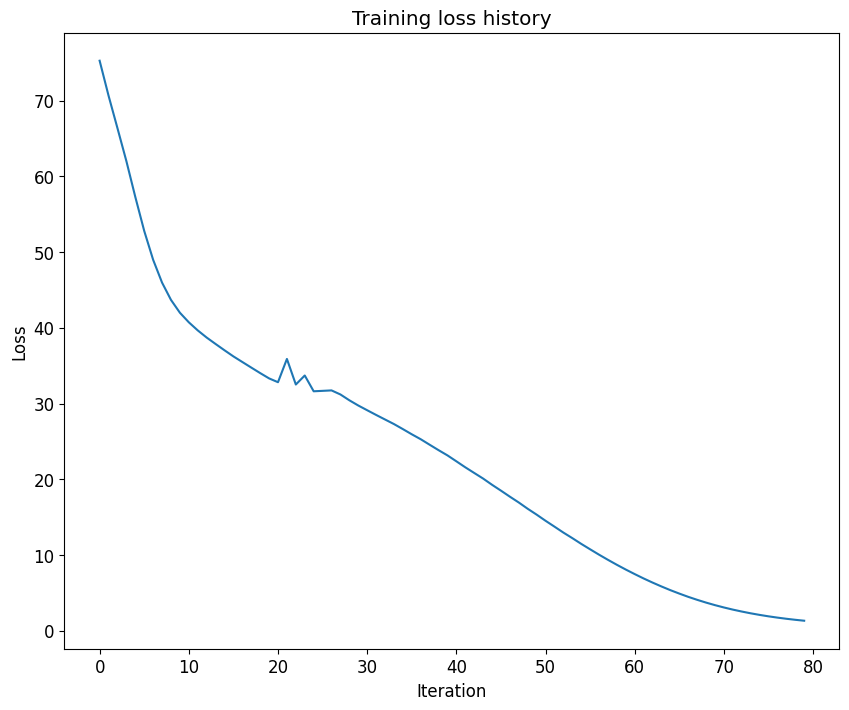

In [20]:
reset_seed(0)

# data input
small_num_train = 50
sample_idx = torch.linspace(0, num_train-1, steps=small_num_train, **to_long_cuda)
small_image_data = data_dict['train_images'].to('cuda')[sample_idx]
small_caption_data = data_dict['train_captions'].to('cuda')[sample_idx]

# optimization arguments
num_epochs = 80
batch_size = 50
  
# create the image captioning model
model = CaptioningRNN(
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_overfit, _ = captioning_train(model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

## Caption sampling
Unlike classification models, image captioning models behave very differently at training time and at test time. At training time, we have access to the ground-truth caption, so we feed ground-truth words as input to the RNN at each timestep. At test time, we sample from the distribution over the vocabulary at each timestep, and feed the sample as input to the RNN at the next timestep.

Implement the `CaptioningRNN.sample` for test-time sampling. After doing so, run the following to train a captioning model and sample from the model on both training and validation data.

### Train the net
After you are done implementing the `CaptioningRNN.sample` method, perform the training on the entire training set. You should see a final loss less than `2.0` and each epoch should take ~6s to run.

learning rate is:  0.001
(Epoch 0 / 60) loss: 47.6768 time per epoch: 2.9s
(Epoch 1 / 60) loss: 41.5438 time per epoch: 2.8s
(Epoch 2 / 60) loss: 38.4301 time per epoch: 2.8s
(Epoch 3 / 60) loss: 36.2271 time per epoch: 2.8s
(Epoch 4 / 60) loss: 34.0922 time per epoch: 2.7s
(Epoch 5 / 60) loss: 32.0878 time per epoch: 2.8s
(Epoch 6 / 60) loss: 30.4448 time per epoch: 2.8s
(Epoch 7 / 60) loss: 28.9082 time per epoch: 2.9s
(Epoch 8 / 60) loss: 27.4608 time per epoch: 2.8s
(Epoch 9 / 60) loss: 26.1133 time per epoch: 2.9s
(Epoch 10 / 60) loss: 24.7777 time per epoch: 2.7s
(Epoch 11 / 60) loss: 23.4889 time per epoch: 2.9s
(Epoch 12 / 60) loss: 22.4113 time per epoch: 2.8s
(Epoch 13 / 60) loss: 21.4224 time per epoch: 2.7s
(Epoch 14 / 60) loss: 20.3996 time per epoch: 2.8s
(Epoch 15 / 60) loss: 19.4289 time per epoch: 2.9s
(Epoch 16 / 60) loss: 18.2477 time per epoch: 2.9s
(Epoch 17 / 60) loss: 17.1050 time per epoch: 2.7s
(Epoch 18 / 60) loss: 16.4182 time per epoch: 2.8s
(Epoch 19 / 60) 

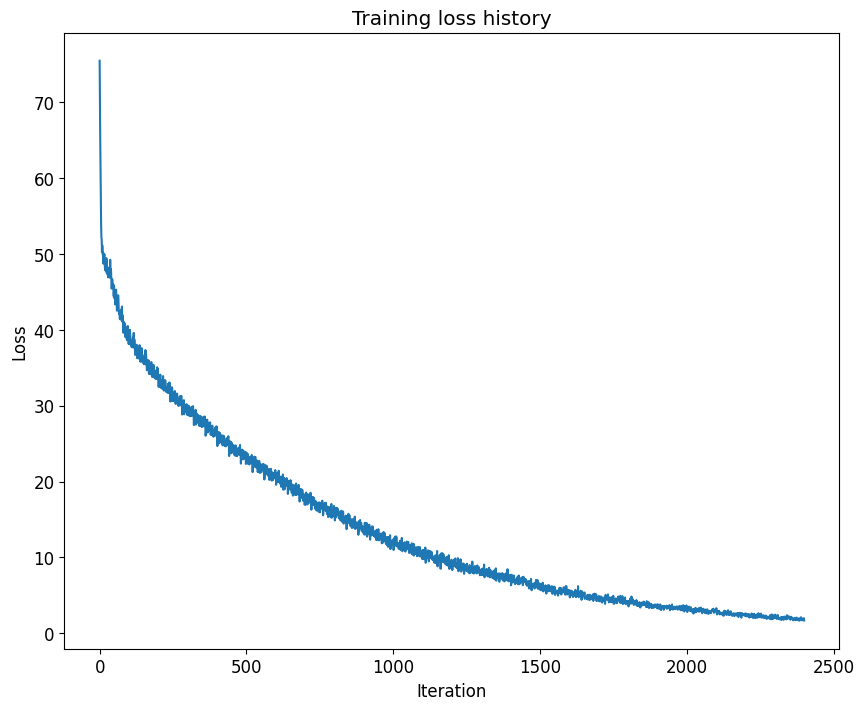

In [21]:
reset_seed(0)

# data input
small_num_train = num_train
sample_idx = torch.randint(num_train, size=(small_num_train,), **to_long_cuda)
small_image_data = data_dict['train_images'].to('cuda')[sample_idx]
small_caption_data = data_dict['train_captions'].to('cuda')[sample_idx]

# optimization arguments
num_epochs = 60
batch_size = 250

# create the image captioning model
rnn_model = CaptioningRNN(
          word_to_idx=data_dict['vocab']['token_to_idx'],
          input_dim=1280, # hard-coded, do not modify
          hidden_dim=512,
          wordvec_dim=256,
          ignore_index=NULL_index,
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  rnn_model_submit, rnn_loss_submit = captioning_train(rnn_model, small_image_data, small_caption_data,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

### Test-time sampling
The samples on training data should be very good; the samples on validation data will probably make less sense.

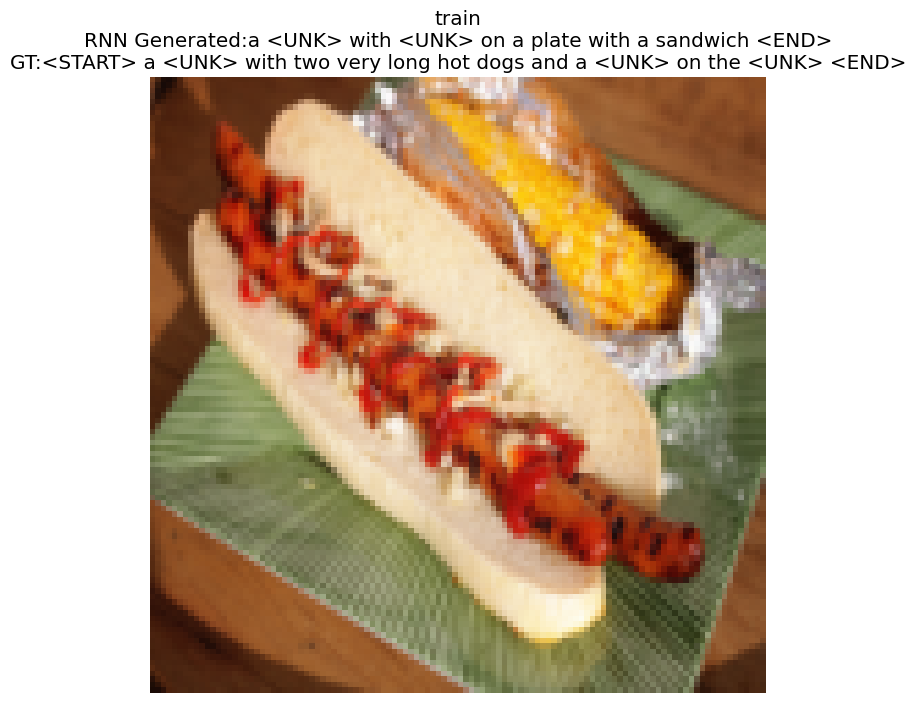

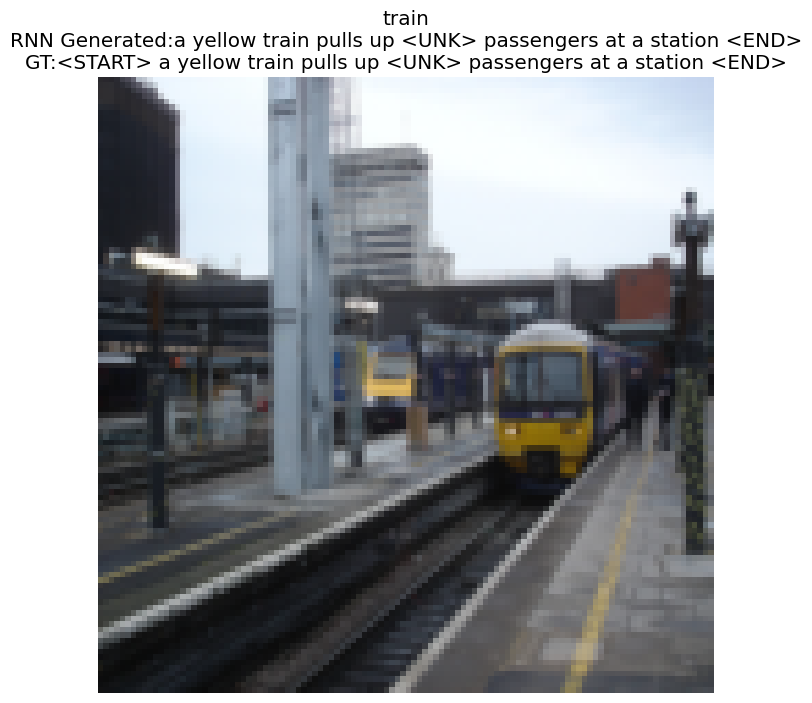

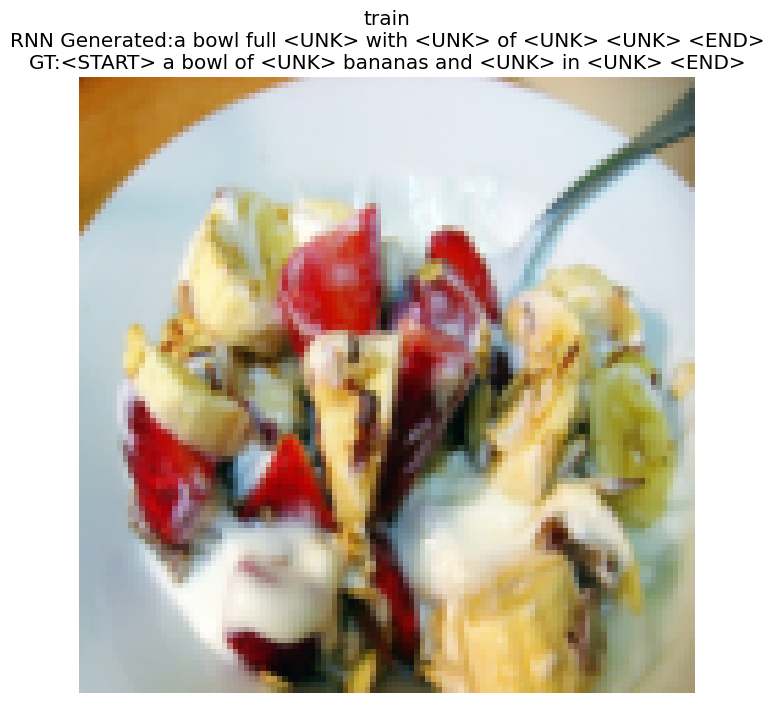

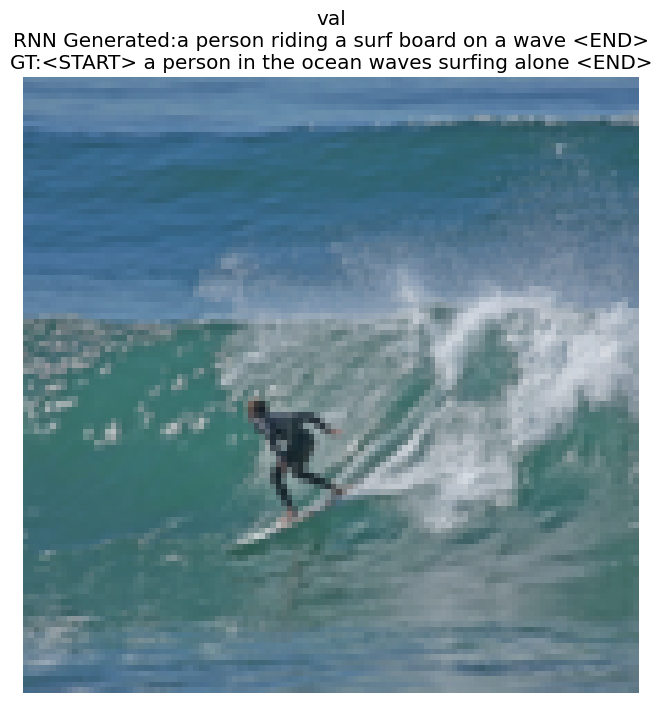

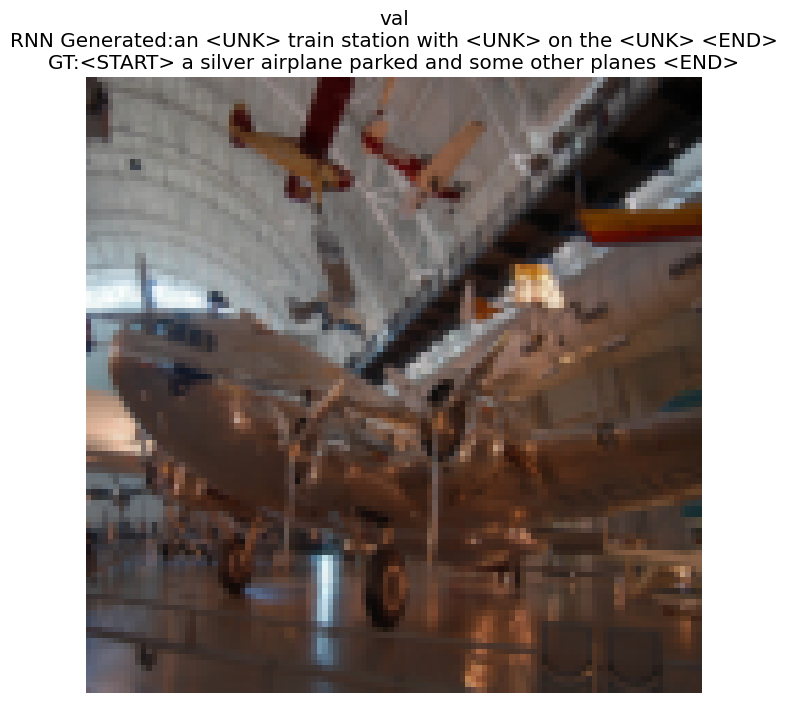

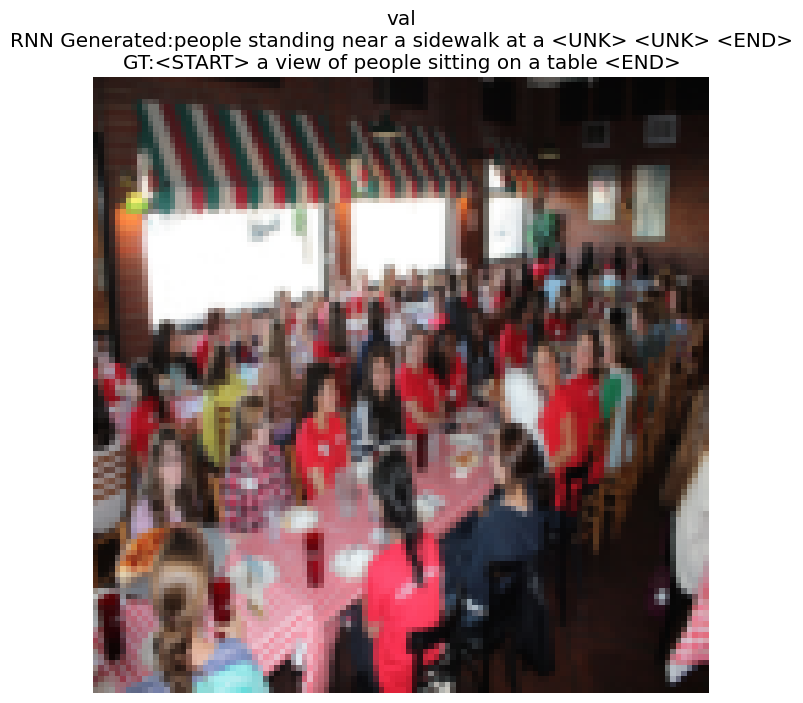

In [22]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.
batch_size = 3

for split in ['train', 'val']:
  sample_idx = torch.randint(0, num_train if split=='train' else num_val, (batch_size,))
  sample_images = data_dict[split+'_images'][sample_idx]
  sample_captions = data_dict[split+'_captions'][sample_idx]

  # decode_captions is loaded from a4_helper.py
  gt_captions = decode_captions(sample_captions, data_dict['vocab']['idx_to_token'])
  rnn_model.eval()
  generated_captions = rnn_model.sample(sample_images)
  generated_captions = decode_captions(generated_captions, data_dict['vocab']['idx_to_token'])

  for i in range(batch_size):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis('off')
    plt.title('%s\nRNN Generated:%s\nGT:%s' % (split, generated_captions[i], gt_captions[i]))
    plt.show()